<a href="https://colab.research.google.com/github/xxx0708/CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 导入包

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

In [ ]:
# 设置transforms
transform = transforms.Compose([
    transforms.ToTensor(), # numpy -> Tensor
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) # 归一化，范围[-1, 1]
])

In [ ]:
# 下载数据集
# 训练集
trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
# 测试集
testset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# 批量读取数据
from torch.utils.data.dataloader import DataLoader

BATCH_SIZE = 12

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)

test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([12, 3, 32, 32])
torch.Size([12])


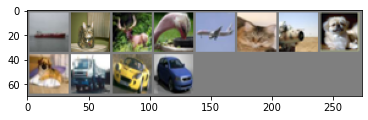

 ship   cat  deer  bird plane   cat plane   dog   dog truck   car   car


In [ ]:
# 可视化显示
import matplotlib.pyplot as plt
import numpy as np

# 10个类别
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # 逆正则化
    np_img = img.numpy() # tensor --> numpy
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # 改变通道顺序
    plt.show()
    
# 随机获取一批数据
imgs, labs = next(iter(train_loader))

print(imgs.shape)
print(labs.shape)

# 调用方法
imshow(torchvision.utils.make_grid(imgs))

# 输出这批图片对应的标签
print(' '.join('%5s' % classes[labs[i]] for i in range(BATCH_SIZE)))

In [ ]:
# 定义网络模型

import torch.nn as nn
import torch.nn.functional as F

"""
1. 特征图尺寸的计算公式为：[(原图片尺寸 — 卷积核尺寸) / 步长 ] + 1
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层1， 输入是32*32*3，计算（32-5）/ 1 + 1 = 28，那么通过conv1输出的结果是28*28*6
        self.conv1 = nn.Conv2d(3, 6, 5) # input:3, output:6, kernel:5
        # 池化层，  输入是28*28*6，窗口2*2，计算28 / 2 = 14，那么通过max_pool1层输出结果是14*14*6
        self.pool = nn.MaxPool2d(2, 2) # kernel:2, stride:2
        # 卷积层2， 输入是14*14*6，计算（14 - 5）/ 1 + 1 = 10，那么通过conv2输出的结果是10*10*16
        self.conv2 = nn.Conv2d(6, 16, 5) # input:6, output:16, kernel:5
        # 池化层，  输入是10*10*16，窗口2*2，计算10 / 2 = 5，那么通过max_pool1层输出结果是5*5*6
        #self.pool = nn.MaxPool2d(2, 2) # kernel:2, stride:2
        # 卷积层3， 输入是5*5*6，计算（10 - 5）/ 1 + 1 = 6，那么通过conv2输出的结果是6*6*32
        self.conv3= nn.Conv2d(16, 32, 5)#input:16,output:32,kernel:5
        #w=10*10*32 ,120
        # 全连接层1
        self.fc1 = nn.Linear(6*6*32, 120) # input:6*6*32, output:120
        # 全连接层2
        self.fc2 = nn.Linear(120, 10) # input:120, output:10
        
    def forward(self, x):
        # 卷积1 
        x = self.pool(F.relu(self.conv1(x)))
        # 卷积2
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # 改变shape
        x = x.view(-1, 32*6*6)
        # 全连接层1
        x = F.relu(self.fc1(x))
        # 全连接层2
        x = self.fc2(x)
        return x

In [ ]:
# 创建模型
net = Net()

In [ ]:
# 定义优化器和损失函数
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 交叉式损失函数

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 优化器

In [ ]:
# 定义轮数
EPOCHS = 20

for epoch in range(EPOCHS):
    
    train_loss = 0.0
    for i, (datas, labels) in enumerate(train_loader):
        datas, labels = datas, labels
        # 梯度置零
        optimizer.zero_grad()
        # 训练
        outputs = net(datas)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # 累计损失
        train_loss += loss.item()
    # 打印信息
    print("Epoch :%d , Batch : %5d , Loss : %.3f"%(epoch+1, i+1, train_loss/len(train_loader.dataset)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch :1 , Batch :  4167 , Loss : 0.156
Epoch :2 , Batch :  4167 , Loss : 0.122
Epoch :3 , Batch :  4167 , Loss : 0.110
Epoch :4 , Batch :  4167 , Loss : 0.101
Epoch :5 , Batch :  4167 , Loss : 0.094
Epoch :6 , Batch :  4167 , Loss : 0.088
Epoch :7 , Batch :  4167 , Loss : 0.084
Epoch :8 , Batch :  4167 , Loss : 0.079
Epoch :9 , Batch :  4167 , Loss : 0.075
Epoch :10 , Batch :  4167 , Loss : 0.072
Epoch :11 , Batch :  4167 , Loss : 0.068
Epoch :12 , Batch :  4167 , Loss : 0.064
Epoch :13 , Batch :  4167 , Loss : 0.061
Epoch :14 , Batch :  4167 , Loss : 0.057
Epoch :15 , Batch :  4167 , Loss : 0.054
Epoch :16 , Batch :  4167 , Loss : 0.051
Epoch :17 , Batch :  4167 , Loss : 0.048
Epoch :18 , Batch :  4167 , Loss : 0.045
Epoch :19 , Batch :  4167 , Loss : 0.043
Epoch :20 , Batch :  4167 , Loss : 0.040


In [ ]:
# 保存模型
PATH = './cifar_net.pth'

torch.save(net.state_dict(), PATH)

In [ ]:
# 加载模型

model = Net()

model.load_state_dict(torch.load(PATH)) 

<All keys matched successfully>

In [ ]:
# 测试
correct = 0
total = 0
with torch.no_grad():
    for i , (datas, labels) in enumerate(test_loader):
        # 输出
        outputs = model(datas) # outputs.data.shape --> torch.Size([128, 10])
        _, predicted = torch.max(outputs.data, dim=1) # 第一个是值的张量，第二个是序号的张量
        # 累计数据量
        total += labels.size(0)  # labels.size() --> torch.Size([128]) , labels.size(0) --> 128
        # 比较有多少个预测正确
        correct += (predicted == labels).sum() # 相同为1，不同为0，利用sum()求总和
    print("在10000张测试集图片上的准确率：{:.3f}%".format(correct / total * 100))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


在10000张测试集图片上的准确率：60.130%
